In [1]:
from biozorromodel import BioZorro
from datasets import load_from_disk
from encoders import BioZorroCollator

In [4]:
lm_datasets = load_from_disk('data/filtered_protein_mrna_genes')

In [5]:
keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
remove = list()
for key in lm_datasets.features.keys():
    if key not in keep:
        remove.append(key)
lm_datasets = lm_datasets.remove_columns(remove)

In [6]:
from torch.utils.data import DataLoader
default_data_collator = BioZorroCollator(pad_len=2048, pad_token=0)
dataloader = DataLoader(lm_datasets.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)

In [33]:
batch = next(iter(dataloader))
batch

{'spliced_index': tensor([[ 17,  60, 184,  ...,   0,   0,   0],
         [159, 223, 565,  ...,   0,   0,   0],
         [ 60, 514, 566,  ...,   0,   0,   0],
         [ 24,  60,  81,  ...,   0,   0,   0]]),
 'unspliced_index': tensor([[160, 295, 324,  ...,   0,   0,   0],
         [120, 266, 268,  ...,   0,   0,   0],
         [121, 426, 483,  ...,   0,   0,   0],
         [ 59, 243, 265,  ...,   0,   0,   0]]),
 'spliced_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'unspliced_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]])}

In [57]:
#https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size
import numpy as np
vocab_size = 18817
num_embeddings = int(75.6496 * np.log(vocab_size + 176.623) - 41.4457)
print(num_embeddings)

703


In [74]:
2.5*10**5*256/8

8000000.0

In [62]:
config = {
    "dim": num_embeddings, #hidden size
    "depth": 3, #layers
    "spliced_input_dim": num_embeddings, #embedding_size
    "unspliced_input_dim": num_embeddings,
    "dim_head":64, #don't know, head hidden size?
    "heads": 4, #num heads
    "ff_mult": 4, #Feed forward multiplier
    "num_fusion_tokens": 16,
    "vocab_size": vocab_size
}

model = BioZorro(**config)

In [63]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(f"{n}:{p.numel()/10**6}")

return_tokens:0.002109
fusion_tokens:0.011248
loss.contrastive_loss.logit_scale:1e-06
attn_pool.norm.gamma:0.000703
attn_pool.to_q.weight:0.179968
attn_pool.to_kv.weight:0.359936
attn_pool.to_out.weight:0.179968
spliced_embedding.gene_encoder.embedding.weight:13.228351
spliced_embedding.gene_encoder.enc_norm.weight:0.000703
spliced_embedding.gene_encoder.enc_norm.bias:0.000703
spliced_embedding.counts_encoder.linear1.weight:0.000703
spliced_embedding.counts_encoder.linear1.bias:0.000703
spliced_embedding.counts_encoder.linear2.weight:0.494209
spliced_embedding.counts_encoder.linear2.bias:0.000703
spliced_embedding.counts_encoder.norm.weight:0.000703
spliced_embedding.counts_encoder.norm.bias:0.000703
unspliced_embedding.gene_encoder.embedding.weight:13.228351
unspliced_embedding.gene_encoder.enc_norm.weight:0.000703
unspliced_embedding.gene_encoder.enc_norm.bias:0.000703
unspliced_embedding.counts_encoder.linear1.weight:0.000703
unspliced_embedding.counts_encoder.linear1.bias:0.000703


In [61]:
outputs = model(**batch)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 703 but got size 128 for tensor number 1 in the list.

In [41]:
outputs

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss=tensor(10.3229, grad_fn=<DivBackward0>), fusion_loss_spliced=tensor(2.3723, grad_fn=<DivBackward0>), fusion_loss_unspliced=tensor(3.2532, grad_fn=<DivBackward0>)), spliced_output=None, unspliced_output=None, fusion_output=None)

In [ ]:
outputs.loss.backward()

In [ ]:
import wandb
wandb.init()

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

epochs=100
optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = epochs * len(dataloader)
progress_bar = tqdm(range(num_training_steps))

#print("Start training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))
## Start model training and defining the training loop
model.train()
for epoch in range(epochs):
    for batch in dataloader:
        #batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        optimizer.zero_grad()
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        wandb.log({"loss":loss.detach().to("cpu")})
    print(f"Epoch {epoch}: loss: {loss.detach()}")
        #
    #if xm.is_master_ordinal(local=False):
    wandb.log({"epoch_loss":loss.detach().to("cpu")})

logger.info("End training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))

In [17]:
from collections import defaultdict
import torch
losses = defaultdict(lambda: torch.Tensor([0.0]).to("cpu"))
losses['test']+=torch.Tensor([1.0])

# Scaling law results

In [172]:
import pandas as pd
nparam = np.array([76.65,38.81,32.5,19.94, 13.64, 7.35])*10**6
nlayers = np.array([24,16,10,6,4,2])
sm_loss = { 'fusion_spliced':[0.05217,0.04588,0.054060,0.0688,0.0625,0.07791],
           'fusion_unspliced':[0.05201,0.04558,0.05395645, 0.06859,0.0624,0.07738],
           'contrastive_loss':[0.051933,0.045817,0.054283, 0.06961,0.0638,0.07857]
}
dm_loss = { 'fusion_spliced':[0.002226,0.002776, 0.0047380,0.005473,0.005522,0.01271],
           'fusion_unspliced':[0.002172,0.002689,0.0047747,0.005403,0.005479,0.01249],
           'contrastive_loss':[0.002259,0.003027,0.0048772,0.005678, 0.005278,0.01522]
}
dm_loss=np.array(list(dm_loss.values())).sum(axis=0)
sm_loss=np.array(list(sm_loss.values())).sum(axis=0)
df = pd.DataFrame.from_dict({'dual':dm_loss,'single':sm_loss,'param':nparam})
df_m = pd.DataFrame.from_dict({'dual':dm_loss/dm_loss.mean(),'single':sm_loss/sm_loss.mean(),'param':nparam})

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f880eabb750> has a label of '_nolegend_' which cannot be automatically added to the legend.
  from ipykernel import kernelapp as app
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f880e757290> has a label of '_nolegend_' which cannot be automatically added to the legend.
  from ipykernel import kernelapp as app
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f880eabb710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  from ipykernel import kernelapp as app
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f880e

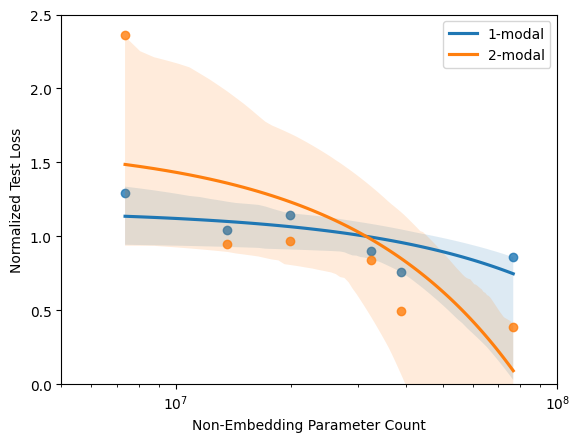

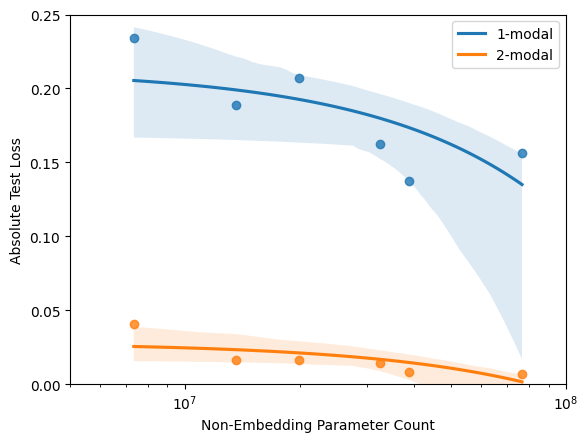

In [186]:
sm_loss_ = sm_loss
dm_loss_ = dm_loss
nparam_ = nparam
nlayers_ = nlayers
plt.figure(1)
#plt.plot(nparam_,np.array(sm_loss_)/sm_loss_.mean(),'o-',
#         nparam_,np.array(dm_loss_)/dm_loss_.mean(),'x-')
sns.regplot(df_m, x='param',y='single')
sns.regplot(df_m, x='param',y='dual')
plt.xscale('log')
plt.xlim([5*10**6,10**8])
plt.ylim([0,2.5])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Normalized Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
plt.figure(2)
#plt.plot(nparam_,np.array(sm_loss_),'o-',
#         nparam_,np.array(dm_loss_),'x-')
sns.regplot(df, x='param',y='single')
sns.regplot(df, x='param',y='dual')
plt.xscale('log')
plt.ylim([0,0.25])

plt.xlim([5*10**6,10**8])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Absolute Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
#, "1-modal", "2-modal"])